In [ ]:
# ============================================
# Setup: imports & display options
# ============================================
!pip install gurobipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

import gurobipy as gp
from gurobipy import GRB

# For nicer printing
pd.set_option("display.float_format", lambda x: f"{x:,.3f}")
plt.rcParams["figure.dpi"] = 120

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.8/14.8 MB 35.3 MB/s eta 0:00:00


In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')


Saving price_demand_data.csv to price_demand_data.csv
User uploaded file "price_demand_data.csv" with length 902 bytes


In [ ]:
# ============================================
# Specific 1: Fit a linear regression model to the price–demand data
# ============================================

# 1. Load the data
#    Make sure "price_demand_data.csv" is in your Colab working directory.
df = pd.read_csv("price_demand_data.csv")

# For safety, rename columns if needed (adjust if your actual column names differ)
# Expecting columns: "price", "demand"
df = df.rename(columns={
    df.columns[0]: "price",   # first column → price
    df.columns[1]: "demand"   # second column → demand
})

print("First few rows of the dataset:")
display(df.head())

# 2. Prepare data for regression: Demand = β0 + β1 * Price + ε
X = df[["price"]].values  # shape (n, 1)
y = df["demand"].values   # shape (n, )

# 3. Fit linear regression using sklearn
linreg = LinearRegression()
linreg.fit(X, y)

beta_0 = linreg.intercept_
beta_1 = linreg.coef_[0]
r2 = linreg.score(X, y)

print(f"Estimated β0 (intercept): {beta_0:.4f}")
print(f"Estimated β1 (slope on price): {beta_1:.4f}")
print(f"R-squared of regression: {r2:.4f}")

# 4. Compute fitted values and residuals ε_i = D_i - (β0 + β1 * p_i)
df["fitted_demand"] = linreg.predict(X)
df["residual"] = df["demand"] - df["fitted_demand"]

print("\nSummary of residuals:")
display(df["residual"].describe())

First few rows of the dataset:


,price,demand
0,1.050,283
1,0.860,771
2,1.210,185
3,0.940,531
4,0.760,1002


Estimated β0 (intercept): 1924.7175
Estimated β1 (slope on price): -1367.7125
R-squared of regression: 0.6215

Summary of residuals:


,residual
count,99.000
mean,-0.000
std,150.213
min,-346.911
25%,-104.548
50%,12.892
75%,100.219
max,341.421


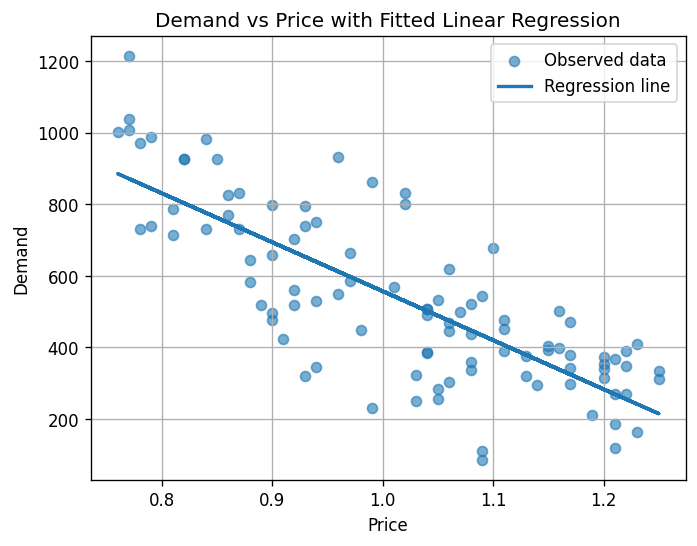

In [ ]:
# ============================================
# Specific 1: Visualization – demand vs price with regression line
# ============================================

plt.figure()
plt.scatter(df["price"], df["demand"], alpha=0.6, label="Observed data")
plt.plot(df["price"], df["fitted_demand"], label="Regression line", linewidth=2)

plt.xlabel("Price")
plt.ylabel("Demand")
plt.title("Demand vs Price with Fitted Linear Regression")
plt.legend()
plt.grid(True)
plt.show()

To start, have modeled how demand depends on price using a simple linear regression of the form

𝐷𝑖=𝛽0+𝛽1𝑝𝑖+𝜀𝑖,
where 𝐷𝑖 is the observed demand on day
𝑖, 𝑝𝑖 is the price on day i, and 𝜀𝑖 is the error term.

Using the provided dataset, the estimated parameters are:

𝛽0=1924.7175

𝛽1=−1367.7125

𝑅2=0.6215

The negative slope 𝛽1 indicates that higher prices are associated with lower demand, which is consistent with intuition. An 𝑅2 of about 0.62 means price explains a substantial portion of the variation in demand, while the remaining variation is captured by the residuals.

The residuals are computed as

𝜀𝑖=𝐷𝑖−(𝛽0+𝛽1𝑝𝑖),
and have mean essentially zero and a standard deviation of about 150. This residual distribution is what I use in the next step to generate simulated demand at a fixed price.

In [ ]:
# ============================================
# Specific 2: Using residuals, assume price p = 1 and generate demand data
# ============================================

# Cost parameters from the project description
c = 0.5   # regular print cost
g = 0.75  # rush print cost
t = 0.15  # disposal cost
p_fixed = 1.0  # fixed selling price for Specifics 2 and 3

print(f"Using c = {c}, g = {g}, t = {t}, and fixed price p = {p_fixed}")

# For each residual ε_i, create synthetic demand at price p = 1:
# D_i(p=1) = β0 + β1 * 1 + ε_i
df["demand_p1"] = beta_0 + beta_1 * p_fixed + df["residual"]

# Demand cannot be negative in this context; clip at zero if necessary
num_negative = (df["demand_p1"] < 0).sum()
if num_negative > 0:
    print(f"\nWARNING: {num_negative} simulated demands were negative; clipping them to 0.")
df["demand_p1"] = df["demand_p1"].clip(lower=0)

print("\nSummary of simulated demand at p = 1:")
display(df["demand_p1"].describe())

Using c = 0.5, g = 0.75, t = 0.15, and fixed price p = 1.0

Summary of simulated demand at p = 1:


,demand_p1
count,99.000
mean,557.005
std,150.213
min,210.094
25%,452.457
50%,569.897
75%,657.224
max,898.426


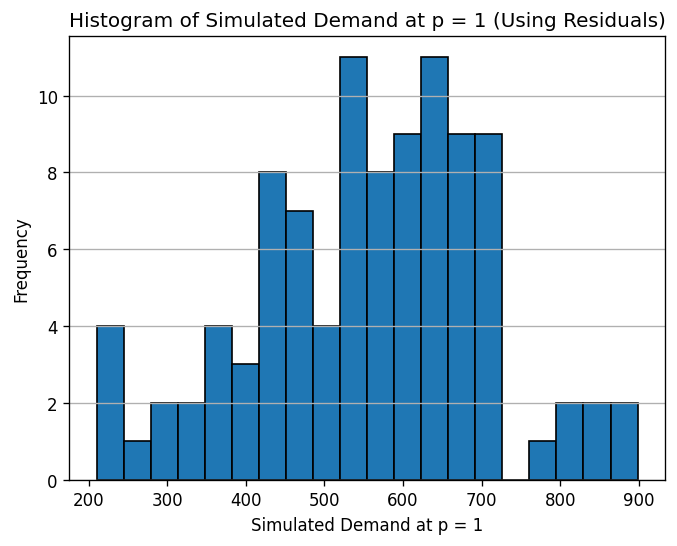

In [ ]:
# ============================================
# Specific 2: Visualization – histogram of simulated demand at p = 1
# ============================================

plt.figure()
plt.hist(df["demand_p1"], bins=20, edgecolor="black")
plt.xlabel("Simulated Demand at p = 1")
plt.ylabel("Frequency")
plt.title("Histogram of Simulated Demand at p = 1 (Using Residuals)")
plt.grid(axis="y")
plt.show()

​In this step, we fix the selling price to p=1 and generate simulated demand data consistent with the regression model from Specific 1.

The project specifies the following cost parameters:
* 𝑐 = 0.5(regular printing cost per unit)
* g=0.75 (rush printing cost per unit)
* t=0.15 (disposal cost per unit)

Using the fitted regression, demand at price p=1 for each observation is constructed as

𝐷𝑖(1)=𝛽0+𝛽1⋅1+𝜀𝑖,Di(1),

where εi are the residuals from the regression in Specific 1.

With 𝛽0=1924.7175 and 𝛽1=−1367.7125, the deterministic part of demand at p=1 is

𝛽0+𝛽1⋅1=1924.7175−1367.7125=557.005.

The simulated demand distribution at p=1 has:
* Mean:557.005
* Standard deviation:150.213
* Minimum:210.094
* Maximum:898.426

No negative values occurred, so there was no need to clip demands at zero. This distribution represents what demand would look like if the firm consistently charged p=1 while preserving the observed randomness in the data.

In [ ]:
# ============================================
# Specific 3: LP – Solve for optimal quantity q when p = 1
# ============================================

# Extract the simulated demand vector at p = 1
D_p1 = df["demand_p1"].to_numpy()
n = len(D_p1)

# Build Gurobi model
m = gp.Model("LP_specific3_p1")

# Decision variable: initial print quantity
q = m.addVar(lb=0.0, name="q")

# Decision variables: u_i (rush quantity), v_i (disposal quantity) for each day
u = m.addVars(n, lb=0.0, name="u")  # shortage (rushed)
v = m.addVars(n, lb=0.0, name="v")  # leftover (disposed)

# Link u_i and v_i to the realized demand and q
for i in range(n):
    # u_i ≥ D_i - q
    m.addConstr(u[i] >= D_p1[i] - q, name=f"rush_link_{i}")
    # v_i ≥ q - D_i
    m.addConstr(v[i] >= q - D_p1[i], name=f"disp_link_{i}")

# Objective: maximize average profit across all days
# profit_i = p * D_i - c * q - g * u_i - t * v_i
profit_expr = gp.quicksum(
    p_fixed * D_p1[i] - c * q - g * u[i] - t * v[i]
    for i in range(n)
) / n

m.setObjective(profit_expr, GRB.MAXIMIZE)

# Optional: turn off verbose Gurobi output if desired
# m.setParam("OutputFlag", 0)

m.optimize()

if m.status == GRB.OPTIMAL:
    q_star = q.X
    print(f"\nOptimal q* (quantity to print at p = 1): {q_star:.4f}")
else:
    print("Model did not converge to an optimal solution.")

Restricted license - for non-production use only - expires 2027-11-29
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 198 rows, 199 columns and 396 nonzeros (Max)
Model fingerprint: 0x3d676308
Model has 199 linear objective coefficients and an objective constant of -5.5700501936651051e+02
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-03, 5e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 9e+02]
Presolve time: 0.01s
Presolved: 198 rows, 199 columns, 396 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.5700502e+02   5.514350e+04   0.000000e+00      0s
      99    2.3148367e+02   0.000000e+00   0.000000e+00      0s

Solved in 99 iterations and 0.02 seconds (0.00 work units)
Optimal objective  2

In [ ]:
# ============================================
# Specific 3: Compute expected profit at the optimal q*
# ============================================

if m.status == GRB.OPTIMAL:
    q_star = q.X # This is the optimal quantity

    # Compute empirical average profit manually (sanity check)
    profits = []
    for i in range(n):
        demand_i = D_p1[i]
        rush_i = max(demand_i - q_star, 0)
        leftover_i = max(q_star - demand_i, 0)
        profit_i = p_fixed * demand_i - c * q_star - g * rush_i - t * leftover_i
        profits.append(profit_i)

    avg_profit = np.mean(profits)
    print(f"Average profit at q* = {q_star:.4f}: {avg_profit:.4f}")

Average profit at q* = 471.8654: 231.4837


In [ ]:
# ============================================
# Specific 4: QP – price impacts demand, optimize p and q
# ============================================

# Residuals from the original regression (already computed above)
eps = df["residual"].to_numpy()
n = len(eps)

m4 = gp.Model("QP_specific4_price_quantity")

# Decision variables: price p, initial print quantity q
p_var = m4.addVar(lb=0.0, name="p")      # selling price
q_var = m4.addVar(lb=0.0, name="q")      # print quantity

# Rush and disposal quantities (same idea as before)
u4 = m4.addVars(n, lb=0.0, name="u")     # shortage (rushed)
v4 = m4.addVars(n, lb=0.0, name="v")     # leftover (disposed)

profit_terms = []

for i in range(n):
    eps_i = eps[i]

    # Demand expression as a function of price p:
    # D_i(p) = beta_0 + beta_1 * p + eps_i
    D_i_expr = beta_0 + beta_1 * p_var + eps_i

    # Link u_i and v_i to D_i(p) and q
    m4.addConstr(u4[i] >= D_i_expr - q_var, name=f"rush_link_{i}")
    m4.addConstr(v4[i] >= q_var - D_i_expr, name=f"disp_link_{i}")

    # Profit on day i:
    # profit_i = p * D_i(p) - c*q - g*u_i - t*v_i
    profit_terms.append(p_var * D_i_expr - c * q_var - g * u4[i] - t * v4[i])

# Objective: maximize average profit over all days
avg_profit_expr_qp = gp.quicksum(profit_terms) / n
m4.setObjective(avg_profit_expr_qp, GRB.MAXIMIZE)

# Optional: quiet output
#m4.setParam("OutputFlag", 0)

m4.optimize()

if m4.status == GRB.OPTIMAL:
    p_star = p_var.X
    q_star = q_var.X
    avg_profit_star = avg_profit_expr_qp.getValue()

    print(f"\n=== Specific 4 results (QP) ===")
    print(f"Optimal price p*: {p_star:.4f}")
    print(f"Optimal quantity q*: {q_star:.4f}")
    print(f"Expected average profit at (p*, q*): {avg_profit_star:.4f}")
else:
    print("QP model did not converge to an optimal solution.")

Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 198 rows, 200 columns and 594 nonzeros (Max)
Model fingerprint: 0x6716132c
Model has 200 linear objective coefficients
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-03, 2e+03]
  QObjective range [3e+03, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+03]
Presolve time: 0.02s
Presolved: 198 rows, 200 columns, 594 nonzeros
Presolved model has 1 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.950e+04
 Factor NZ  : 1.970e+04
 Factor Ops : 2.607e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     

In [ ]:
# ============================================
# Helper: solve optimal (p, q) for given betas & residuals
# ============================================

def solve_optimal_price_quantity(beta_0_hat, beta_1_hat, residuals,
                                 c=c, g=g, t=t, verbose=False):
    """
    Given regression coefficients and residuals, solve the QP:
    max (1/n) sum_i [ p * D_i(p) - c*q - g*u_i - t*v_i ]
    where D_i(p) = beta_0_hat + beta_1_hat * p + residual_i.
    Returns (p_star, q_star, avg_profit_star).
    """
    n = len(residuals)

    m = gp.Model("QP_price_quantity_bootstrap")
    if not verbose:
        m.Params.OutputFlag = 0

    p = m.addVar(lb=0.0, name="p")
    q = m.addVar(lb=0.0, name="q")
    u = m.addVars(n, lb=0.0, name="u")
    v = m.addVars(n, lb=0.0, name="v")

    profit_terms = []
    for i in range(n):
        eps_i = residuals[i]
        D_i_expr = beta_0_hat + beta_1_hat * p + eps_i

        m.addConstr(u[i] >= D_i_expr - q, name=f"rush_{i}")
        m.addConstr(v[i] >= q - D_i_expr, name=f"disp_{i}")

        profit_terms.append(p * D_i_expr - c * q - g * u[i] - t * v[i])

    avg_profit_expr = gp.quicksum(profit_terms) / n
    m.setObjective(avg_profit_expr, GRB.MAXIMIZE)

    m.optimize()

    if m.status != GRB.OPTIMAL:
        raise RuntimeError("Gurobi did not find an optimal solution.")

    p_star = p.X
    q_star = q.X
    avg_profit_star = avg_profit_expr.getValue()

    return p_star, q_star, avg_profit_star

In [ ]:
# ============================================
# Specific 6: Single bootstrap & optimal (p, q)
# ============================================

# Keep a "clean" copy of the original price–demand data
df_raw = df[["price", "demand"]].copy()

n_orig = len(df_raw)
boot_idx = np.random.randint(0, n_orig, size=n_orig)
df_boot = df_raw.iloc[boot_idx].reset_index(drop=True)

# Refit regression on bootstrap sample
X_boot = df_boot[["price"]].values
y_boot = df_boot["demand"].values

linreg_boot = LinearRegression()
linreg_boot.fit(X_boot, y_boot)

beta0_boot = linreg_boot.intercept_
beta1_boot = linreg_boot.coef_[0]

df_boot["fitted"] = linreg_boot.predict(X_boot)
df_boot["residual"] = y_boot - df_boot["fitted"]

print("Bootstrap regression coefficients:")
print(f"  beta0_boot = {beta0_boot:.4f}")
print(f"  beta1_boot = {beta1_boot:.4f}")

# Solve for optimal price & quantity using the helper
p_star_boot, q_star_boot, profit_star_boot = solve_optimal_price_quantity(
    beta0_boot, beta1_boot, df_boot["residual"].to_numpy(), verbose=True
)

print("\n=== Specific 6 results (one bootstrap) ===")
print(f"Optimal price p* (boot): {p_star_boot:.4f}")
print(f"Optimal quantity q* (boot): {q_star_boot:.4f}")
print(f"Expected avg profit (boot): {profit_star_boot:.4f}")

Bootstrap regression coefficients:
  beta0_boot = 1854.8779
  beta1_boot = -1307.1810
Gurobi Optimizer version 13.0.0 build v13.0.0rc1 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Optimize a model with 198 rows, 200 columns and 594 nonzeros (Max)
Model fingerprint: 0x0c748323
Model has 200 linear objective coefficients
Model has 1 quadratic objective term
Coefficient statistics:
  Matrix range     [1e+00, 1e+03]
  Objective range  [2e-03, 2e+03]
  QObjective range [3e+03, 3e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+03, 2e+03]
Presolve time: 0.01s
Presolved: 198 rows, 200 columns, 594 nonzeros
Presolved model has 1 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 1.950e+04
 Factor NZ  : 1.970e+04
 Factor Ops : 2.607e+06 (less than 1 second per iteration)
 Threads    : 1

                  Objecti

In [ ]:
# ============================================
# Specific 7: Repeat many bootstraps, collect (p*, q*, profit*)
# ============================================

B = 200   # number of bootstrap replications (change if you want more/less)

boot_results = []

for b in range(B):
    # Bootstrap sample
    idx = np.random.randint(0, n_orig, size=n_orig)
    df_b = df_raw.iloc[idx].reset_index(drop=True)

    X_b = df_b[["price"]].values
    y_b = df_b["demand"].values

    lr_b = LinearRegression()
    lr_b.fit(X_b, y_b)

    beta0_b = lr_b.intercept_
    beta1_b = lr_b.coef_[0]

    fitted_b = lr_b.predict(X_b)
    residuals_b = y_b - fitted_b

    # Solve QP for this bootstrap
    p_b, q_b, profit_b = solve_optimal_price_quantity(
        beta0_b, beta1_b, residuals_b, verbose=False
    )

    boot_results.append((p_b, q_b, profit_b))

boot_df = pd.DataFrame(boot_results, columns=["p_star", "q_star", "avg_profit"])
display(boot_df.describe())

,p_star,q_star,avg_profit
count,200.000,200.000,200.000
mean,0.953,538.450,234.941
std,0.014,32.489,8.766
min,0.918,454.036,211.801
25%,0.943,513.876,228.451
50%,0.953,532.224,235.552
75%,0.963,563.756,241.172
max,0.999,627.598,258.280


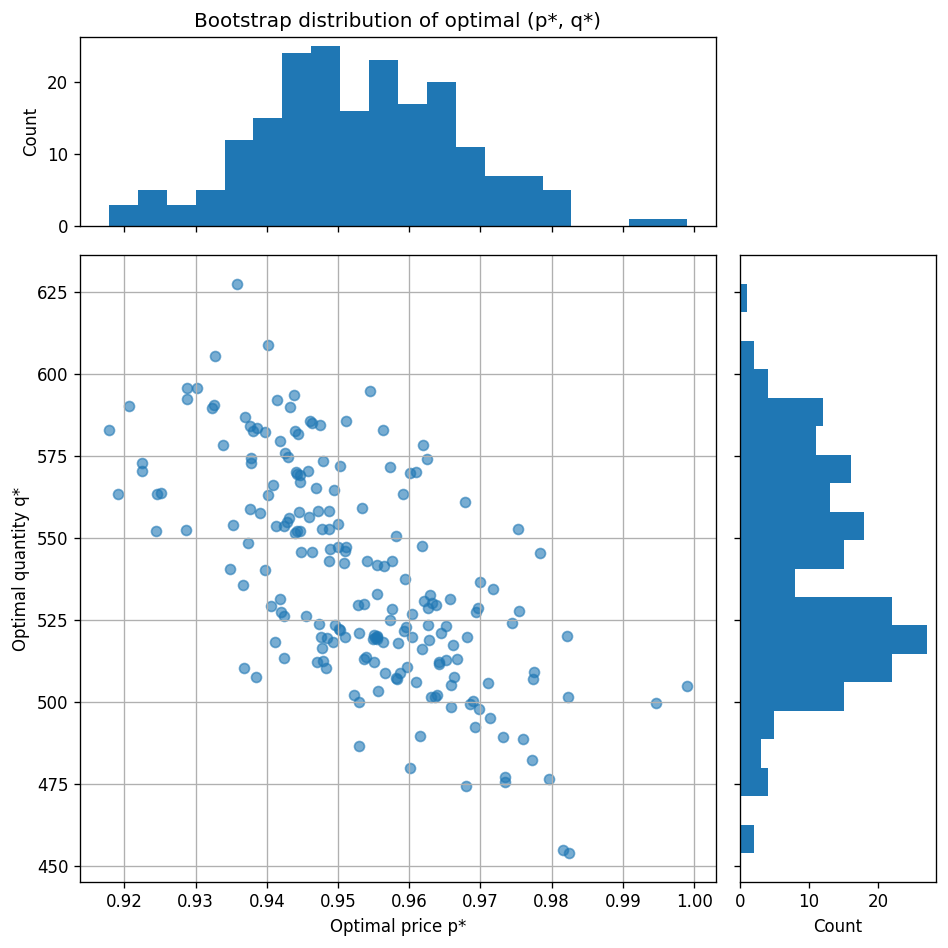

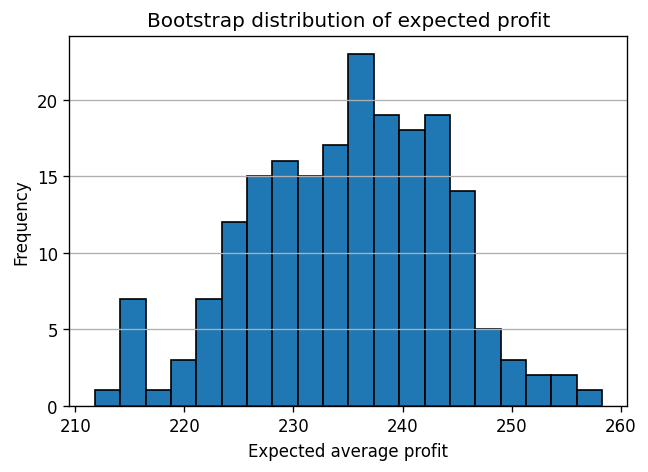

In [ ]:
# ============================================
# Specific 7: Plots: scatter with marginal histograms + profit histogram
# ============================================
import matplotlib.gridspec as gridspec

# Scatter with histograms on top and right
fig = plt.figure(figsize=(8, 8))
gs = gridspec.GridSpec(4, 4)

ax_hist_x = fig.add_subplot(gs[0, 0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])
ax_scatter = fig.add_subplot(gs[1:4, 0:3])

# Scatter of (p*, q*)
ax_scatter.scatter(boot_df["p_star"], boot_df["q_star"], alpha=0.6)
ax_scatter.set_xlabel("Optimal price p*")
ax_scatter.set_ylabel("Optimal quantity q*")
ax_scatter.grid(True)

# Histogram of p* on top
ax_hist_x.hist(boot_df["p_star"], bins=20)
ax_hist_x.set_ylabel("Count")
ax_hist_x.set_title("Bootstrap distribution of optimal (p*, q*)")
ax_hist_x.tick_params(labelbottom=False)

# Histogram of q* on the right
ax_hist_y.hist(boot_df["q_star"], bins=20, orientation="horizontal")
ax_hist_y.set_xlabel("Count")
ax_hist_y.tick_params(labelleft=False)

plt.tight_layout()
plt.show()

# Histogram of expected profits
plt.figure(figsize=(6,4))
plt.hist(boot_df["avg_profit"], bins=20, edgecolor="black")
plt.xlabel("Expected average profit")
plt.ylabel("Frequency")
plt.title("Bootstrap distribution of expected profit")
plt.grid(axis="y")
plt.show()

In [ ]:
import numpy as np
import gurobipy as gp
from gurobipy import GRB
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


def solve_standard_newsvendor_price_and_quantity(beta_0_hat, beta_1_hat, residuals, c, verbose=False):
    """
    Solve the STANDARD newsvendor model but optimize BOTH price and quantity.

    Objective: max (1/n) * sum(p * min(q, D_i) - q*c)
    Where: D_i = beta_0 + beta_1 * p + residuals[i]

    This becomes a QCP (Quadratically Constrained Program) because:
    - Revenue = p * min(q, D_i) and D_i depends on p
    - So we get p * (beta_0 + beta_1*p + eps_i) terms which are quadratic

    Parameters:
    -----------
    beta_0_hat : float
        Intercept from regression
    beta_1_hat : float
        Slope from regression
    residuals : array-like
        Residuals from regression
    c : float
        Unit production cost
    verbose : bool
        Whether to print Gurobi output

    Returns:
    --------
    p_star : float
        Optimal price
    q_star : float
        Optimal quantity
    expected_profit : float
        Expected profit (without rush/disposal - boss's optimistic estimate)
    """
    n = len(residuals)

    # Create the Gurobi model
    m = gp.Model("Standard_NV_with_Price_Optimization_QCP")
    if not verbose:
        m.Params.OutputFlag = 0

    # Decision variables
    p = m.addVar(lb=0.0, name="p")  # Price
    q = m.addVar(lb=0.0, name="q")  # Quantity

    # Auxiliary variables h_i for each scenario's profit
    h = m.addVars(n, lb=-GRB.INFINITY, name="h")

    # Add constraints for each scenario
    for i in range(n):
        eps_i = residuals[i]

        # CONSTRAINT 1: h_i <= p*D_i - q*c  (profit if we sell all demand)
        # Substituting D_i: h_i <= p*(beta_0 + beta_1*p + eps_i) - q*c
        # This is: h_i <= p*beta_0 + beta_1*p^2 + p*eps_i - q*c
        # This is a QUADRATIC constraint because of the p^2 term
        m.addQConstr(
            h[i] <= p * beta_0_hat + beta_1_hat * p * p + p * eps_i - q * c,
            name=f"profit_sell_demand_{i}"
        )

        # CONSTRAINT 2: h_i <= p*q - q*c  (profit if we sell all production)
        # This is LINEAR in our decision variables
        m.addConstr(
            h[i] <= p * q - q * c,
            name=f"profit_sell_production_{i}"
        )

    # Objective: maximize average profit across all scenarios
    avg_profit = gp.quicksum(h[i] for i in range(n)) / n
    m.setObjective(avg_profit, GRB.MAXIMIZE)

    # Solve the model
    m.optimize()

    # Check if we found an optimal solution
    if m.status != GRB.OPTIMAL:
        raise RuntimeError("Gurobi did not find an optimal solution for standard newsvendor with price optimization.")

    # Extract the optimal values
    p_star = p.X
    q_star = q.X
    expected_profit = avg_profit.getValue()

    return p_star, q_star, expected_profit


def evaluate_profit_with_extensions(p, q, beta_0_hat, beta_1_hat, residuals, c, g, t):
    """
    Given a FIXED price and quantity, calculate the ACTUAL profit you'd get
    in the real world where rush orders and disposal costs exist.

    Real profit formula for each day:
        profit_i = p * min(q, D_i) - q*c - g*max(D_i - q, 0) - t*max(q - D_i, 0)

    Where:
        - p * min(q, D_i): Revenue from selling
        - q * c: Production cost
        - g * max(D_i - q, 0): Rush order cost when demand exceeds production
        - t * max(q - D_i, 0): Disposal cost when production exceeds demand

    Parameters:
    -----------
    p : float
        Selling price
    q : float
        Quantity produced
    beta_0_hat : float
        Intercept from regression
    beta_1_hat : float
        Slope from regression
    residuals : array-like
        Residuals from regression
    c : float
        Unit production cost
    g : float
        Rush order cost per unit
    t : float
        Disposal cost per unit

    Returns:
    --------
    avg_profit : float
        Average actual profit across all demand scenarios
    """
    # Generate demand scenarios for this price
    demand_data = beta_0_hat + beta_1_hat * p + residuals

    profits = []

    for D_i in demand_data:
        # Revenue: sell the minimum of what we produced and what was demanded
        revenue = p * min(q, D_i)

        # Cost: always pay to produce q units
        production_cost = q * c

        # Rush cost: if demand exceeds production, we need to rush order the difference
        rush_cost = g * max(D_i - q, 0)

        # Disposal cost: if production exceeds demand, we need to dispose of excess
        disposal_cost = t * max(q - D_i, 0)

        # Calculate total profit for this day
        profit_i = revenue - production_cost - rush_cost - disposal_cost
        profits.append(profit_i)

    # Return average profit across all days
    return np.mean(profits)


def bootstrap_model_comparison(original_price_data, original_demand_data,
                               solve_extended_model_func,
                               n_bootstrap=1000, c=0.5, g=0.75, t=0.15,
                               verbose=False):
    """
    Compare the standard newsvendor model (boss - optimizes price/quantity but ignores rush/disposal)
    vs. the extended model (you - optimizes price/quantity WITH rush/disposal costs).

    Uses sklearn's LinearRegression for cleaner, more robust regression fitting.

    For each bootstrap sample:
    1. Resample the original price/demand data WITH replacement
    2. Fit new regression coefficients using sklearn.linear_model.LinearRegression
    3. Calculate residuals (these capture demand uncertainty)
    4. Solve boss's standard NV model (optimizes p and q, ignores rush/disposal)
    5. Evaluate boss's solution with ACTUAL rush/disposal costs
    6. Solve your extended model (optimizes p and q WITH rush/disposal)
    7. Compare actual profits

    Parameters:
    -----------
    original_price_data : array-like
        Original price observations from dataset
    original_demand_data : array-like
        Original demand observations from dataset
    solve_extended_model_func : function
        Your function that solves the extended QP model with rush/disposal
        Should have signature: solve_extended_model_func(beta_0_hat, beta_1_hat, residuals, c, g, t, verbose)
        Should return: (p_star, q_star, expected_profit)
    n_bootstrap : int
        Number of bootstrap samples to generate
    c, g, t : float
        Cost parameters
    verbose : bool
        Whether to print progress

    Returns:
    --------
    results : dict
        Dictionary containing lists of results from each bootstrap
    """

    # Convert to numpy arrays for easier manipulation
    prices = np.array(original_price_data)
    demands = np.array(original_demand_data)
    n_original = len(prices)

    # Storage for results from each bootstrap iteration
    boss_prices = []
    boss_quantities = []
    boss_optimistic_profits = []  # What boss thinks they'll get
    boss_actual_profits = []  # What boss actually gets (with rush/disposal)

    extended_prices = []
    extended_quantities = []
    extended_actual_profits = []

    # Run bootstrap iterations
    for iteration in range(n_bootstrap):
        if verbose and (iteration % 100 == 0):
            print(f"Bootstrap iteration {iteration}/{n_bootstrap}")

        # STEP 1: Create bootstrap sample by resampling WITH replacement
        # This simulates drawing a new dataset from the same underlying distribution
        bootstrap_indices = np.random.choice(n_original, size=n_original, replace=True)
        bootstrap_prices = prices[bootstrap_indices]
        bootstrap_demands = demands[bootstrap_indices]

        # STEP 2: Fit linear regression to bootstrap sample using sklearn
        # We're fitting: demand = beta_0 + beta_1 * price + epsilon

        # Initialize the linear regression model
        model = LinearRegression()

        # Fit the model (sklearn requires X to be 2D, hence reshape)
        model.fit(bootstrap_prices.reshape(-1, 1), bootstrap_demands)

        # Extract coefficients
        beta_1_hat = model.coef_[0]  # Slope (usually negative for price)
        beta_0_hat = model.intercept_  # Intercept

        # STEP 3: Calculate residuals from this regression
        # These residuals represent the UNCERTAINTY in demand
        # residuals = actual demand - predicted demand
        predicted_demands = model.predict(bootstrap_prices.reshape(-1, 1))
        residuals = bootstrap_demands - predicted_demands

        # STEP 4: Evaluate BOSS'S standard newsvendor model
        # Boss optimizes BOTH price and quantity but ignores rush/disposal costs

        try:
            p_boss, q_boss, optimistic_profit_boss = solve_standard_newsvendor_price_and_quantity(
                beta_0_hat=beta_0_hat,
                beta_1_hat=beta_1_hat,
                residuals=residuals,
                c=c,
                verbose=False
            )
        except Exception as e:
            if verbose:
                print(f"Warning: Boss's model failed in iteration {iteration}: {e}")
            continue  # Skip this iteration if boss's model fails

        # STEP 5: Calculate what profit boss ACTUALLY gets in reality
        # Boss chose (p_boss, q_boss) thinking they'd get optimistic_profit_boss
        # But in reality, rush and disposal costs occur!
        actual_profit_boss = evaluate_profit_with_extensions(
            p=p_boss,
            q=q_boss,
            beta_0_hat=beta_0_hat,
            beta_1_hat=beta_1_hat,
            residuals=residuals,
            c=c,
            g=g,
            t=t
        )

        # Store boss's results
        boss_prices.append(p_boss)
        boss_quantities.append(q_boss)
        boss_optimistic_profits.append(optimistic_profit_boss)
        boss_actual_profits.append(actual_profit_boss)

        # STEP 6: Evaluate YOUR extended model
        # Your model optimizes BOTH price and quantity WITH rush/disposal costs included

        try:
            p_extended, q_extended, profit_extended = solve_extended_model_func(
                beta_0_hat=beta_0_hat,
                beta_1_hat=beta_1_hat,
                residuals=residuals,
                c=c,
                g=g,
                t=t,
                verbose=False
            )
        except Exception as e:
            if verbose:
                print(f"Warning: Extended model failed in iteration {iteration}: {e}")
            # Remove the boss's results from this iteration too
            boss_prices.pop()
            boss_quantities.pop()
            boss_optimistic_profits.pop()
            boss_actual_profits.pop()
            continue  # Skip this iteration if extended model fails

        # Store your extended model's results
        extended_prices.append(p_extended)
        extended_quantities.append(q_extended)
        extended_actual_profits.append(profit_extended)

    # Package all results into a dictionary
    results = {
        'boss_prices': np.array(boss_prices),
        'boss_quantities': np.array(boss_quantities),
        'boss_optimistic_profits': np.array(boss_optimistic_profits),
        'boss_actual_profits': np.array(boss_actual_profits),
        'extended_prices': np.array(extended_prices),
        'extended_quantities': np.array(extended_quantities),
        'extended_actual_profits': np.array(extended_actual_profits)
    }

    if verbose:
        print(f"\nCompleted {len(results['boss_actual_profits'])} successful bootstrap iterations out of {n_bootstrap} attempted.")

    return results


def visualize_bootstrap_comparison(results):
    """
    Create comprehensive visualizations comparing the two models.

    Includes comparison of boss's optimistic vs actual profits!

    Parameters:
    -----------
    results : dict
        Output from bootstrap_model_comparison()
    """

    # Set style for publication-quality plots
    sns.set_style("whitegrid")

    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(18, 12))

    # PLOT 1: Profit comparison histogram (ACTUAL profits only)
    ax1 = plt.subplot(2, 4, 1)
    plt.hist(results['boss_actual_profits'], bins=50, alpha=0.6,
             label='Standard NV (Boss Actual)', color='red', edgecolor='black')
    plt.hist(results['extended_actual_profits'], bins=50, alpha=0.6,
             label='Extended Model (You)', color='green', edgecolor='black')
    plt.xlabel('Expected Profit ($)', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title('Actual Profit Distribution Comparison', fontsize=13, fontweight='bold')
    plt.legend(fontsize=9)
    plt.axvline(np.mean(results['boss_actual_profits']), color='darkred',
                linestyle='--', linewidth=2, alpha=0.7)
    plt.axvline(np.mean(results['extended_actual_profits']), color='darkgreen',
                linestyle='--', linewidth=2, alpha=0.7)

    # PLOT 2: Boss's Optimistic vs Actual profits
    ax2 = plt.subplot(2, 4, 2)
    plt.hist(results['boss_optimistic_profits'], bins=50, alpha=0.6,
             label='Boss Optimistic', color='orange', edgecolor='black')
    plt.hist(results['boss_actual_profits'], bins=50, alpha=0.6,
             label='Boss Actual', color='red', edgecolor='black')
    plt.xlabel('Expected Profit ($)', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title("Boss's Optimistic vs Actual", fontsize=13, fontweight='bold')
    plt.legend(fontsize=9)

    # PLOT 3: Profit improvement distribution
    ax3 = plt.subplot(2, 4, 3)
    profit_improvement = results['extended_actual_profits'] - results['boss_actual_profits']
    plt.hist(profit_improvement, bins=50, color='blue', alpha=0.7, edgecolor='black')
    plt.xlabel('Profit Improvement ($)', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title('Profit Improvement: You - Boss', fontsize=13, fontweight='bold')
    plt.axvline(np.mean(profit_improvement), color='darkblue',
                linestyle='--', linewidth=2, label=f'Mean: ${np.mean(profit_improvement):.2f}')
    plt.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    plt.legend(fontsize=9)

    # PLOT 4: Price comparison
    ax4 = plt.subplot(2, 4, 4)
    plt.hist(results['boss_prices'], bins=50, alpha=0.6,
             label='Standard NV', color='red', edgecolor='black')
    plt.hist(results['extended_prices'], bins=50, alpha=0.6,
             label='Extended Model', color='green', edgecolor='black')
    plt.xlabel('Optimal Price ($)', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title('Price Distribution Comparison', fontsize=13, fontweight='bold')
    plt.legend(fontsize=9)

    # PLOT 5: Quantity comparison
    ax5 = plt.subplot(2, 4, 5)
    plt.hist(results['boss_quantities'], bins=50, alpha=0.6,
             label='Standard NV', color='red', edgecolor='black')
    plt.hist(results['extended_quantities'], bins=50, alpha=0.6,
             label='Extended Model', color='green', edgecolor='black')
    plt.xlabel('Optimal Quantity', fontsize=11)
    plt.ylabel('Frequency', fontsize=11)
    plt.title('Quantity Distribution Comparison', fontsize=13, fontweight='bold')
    plt.legend(fontsize=9)

    # PLOT 6: Price vs Quantity for Boss
    ax6 = plt.subplot(2, 4, 6)
    plt.scatter(results['boss_prices'], results['boss_quantities'],
                alpha=0.3, color='red', s=20)
    plt.xlabel('Optimal Price ($)', fontsize=11)
    plt.ylabel('Optimal Quantity', fontsize=11)
    plt.title('Boss: Price vs Quantity', fontsize=13, fontweight='bold')
    corr_boss = np.corrcoef(results['boss_prices'], results['boss_quantities'])[0, 1]
    plt.text(0.05, 0.95, f'Corr: {corr_boss:.3f}',
             transform=ax6.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

    # PLOT 7: Price vs Quantity for Extended Model
    ax7 = plt.subplot(2, 4, 7)
    plt.scatter(results['extended_prices'], results['extended_quantities'],
                alpha=0.3, color='green', s=20)
    plt.xlabel('Optimal Price ($)', fontsize=11)
    plt.ylabel('Optimal Quantity', fontsize=11)
    plt.title('Extended: Price vs Quantity', fontsize=13, fontweight='bold')
    corr_extended = np.corrcoef(results['extended_prices'], results['extended_quantities'])[0, 1]
    plt.text(0.05, 0.95, f'Corr: {corr_extended:.3f}',
             transform=ax7.transAxes, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5), fontsize=9)

    # PLOT 8: Cumulative distribution functions
    ax8 = plt.subplot(2, 4, 8)
    sorted_boss = np.sort(results['boss_actual_profits'])
    sorted_extended = np.sort(results['extended_actual_profits'])
    cumulative = np.arange(1, len(sorted_boss) + 1) / len(sorted_boss)

    plt.plot(sorted_boss, cumulative, label='Standard NV (Boss)',
             color='red', linewidth=2)
    plt.plot(sorted_extended, cumulative, label='Extended Model (You)',
             color='green', linewidth=2)
    plt.xlabel('Expected Profit ($)', fontsize=11)
    plt.ylabel('Cumulative Probability', fontsize=11)
    plt.title('CDF of Actual Profits', fontsize=13, fontweight='bold')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('bootstrap_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print comprehensive summary statistics
    print("\n" + "="*70)
    print("BOOTSTRAP COMPARISON SUMMARY STATISTICS")
    print("="*70)
    print(f"\nNumber of bootstrap samples: {len(results['boss_actual_profits'])}")

    print("\n" + "-"*70)
    print("STANDARD NEWSVENDOR MODEL (Boss's Approach)")
    print("Boss optimizes price & quantity but IGNORES rush/disposal costs")
    print("-"*70)
    print(f"Mean Optimistic Profit: ${np.mean(results['boss_optimistic_profits']):.2f}  (what boss thinks)")
    print(f"Mean ACTUAL Profit:     ${np.mean(results['boss_actual_profits']):.2f}  (what boss gets)")
    print(f"Boss's Reality Gap:     ${np.mean(results['boss_optimistic_profits'] - results['boss_actual_profits']):.2f}  (cost of ignoring rush/disposal)")
    print(f"\nMedian Actual Profit:   ${np.median(results['boss_actual_profits']):.2f}")
    print(f"Std Dev Actual Profit:  ${np.std(results['boss_actual_profits']):.2f}")
    print(f"Min Actual Profit:      ${np.min(results['boss_actual_profits']):.2f}")
    print(f"Max Actual Profit:      ${np.max(results['boss_actual_profits']):.2f}")
    print(f"\nMean Price:             ${np.mean(results['boss_prices']):.2f}")
    print(f"Std Dev Price:          ${np.std(results['boss_prices']):.2f}")
    print(f"Mean Quantity:          {np.mean(results['boss_quantities']):.2f}")
    print(f"Std Dev Quantity:       {np.std(results['boss_quantities']):.2f}")

    print("\n" + "-"*70)
    print("EXTENDED MODEL (Your Proposed Approach)")
    print("You optimize price & quantity WITH rush/disposal costs included")
    print("-"*70)
    print(f"Mean Profit:            ${np.mean(results['extended_actual_profits']):.2f}")
    print(f"Median Profit:          ${np.median(results['extended_actual_profits']):.2f}")
    print(f"Std Dev Profit:         ${np.std(results['extended_actual_profits']):.2f}")
    print(f"Min Profit:             ${np.min(results['extended_actual_profits']):.2f}")
    print(f"Max Profit:             ${np.max(results['extended_actual_profits']):.2f}")
    print(f"\nMean Price:             ${np.mean(results['extended_prices']):.2f}")
    print(f"Std Dev Price:          ${np.std(results['extended_prices']):.2f}")
    print(f"Mean Quantity:          {np.mean(results['extended_quantities']):.2f}")
    print(f"Std Dev Quantity:       {np.std(results['extended_quantities']):.2f}")

    print("\n" + "-"*70)
    print("IMPROVEMENT (Extended - Boss's Actual)")
    print("-"*70)
    profit_diff = results['extended_actual_profits'] - results['boss_actual_profits']
    print(f"Mean Profit Improvement:   ${np.mean(profit_diff):.2f}")
    print(f"Median Profit Improvement: ${np.median(profit_diff):.2f}")
    print(f"Std Dev of Improvement:    ${np.std(profit_diff):.2f}")

    # Calculate percentage improvement
    pct_improvement = (np.mean(results['extended_actual_profits']) /
                      np.mean(results['boss_actual_profits']) - 1) * 100
    print(f"\nPercentage Improvement:    {pct_improvement:.2f}%")

    # How often is extended model better?
    pct_better = np.mean(profit_improvement > 0) * 100
    print(f"Extended model better:     {pct_better:.1f}% of the time")

    # Statistical significance test
    t_stat, p_value = stats.ttest_rel(results['extended_actual_profits'],
                                       results['boss_actual_profits'])
    print(f"\nPaired t-test statistic:   {t_stat:.4f}")
    print(f"Paired t-test p-value:     {p_value:.6f}")
    if p_value < 0.05:
        print("Result: Statistically significant improvement (p < 0.05) ✓")
    else:
        print("Result: Not statistically significant (p >= 0.05)")

    # Confidence interval for improvement
    ci_95 = stats.t.interval(0.95, len(profit_diff)-1,
                             loc=np.mean(profit_diff),
                             scale=stats.sem(profit_diff))
    print(f"\n95% Confidence Interval for improvement: [${ci_95[0]:.2f}, ${ci_95[1]:.2f}]")

    print("="*70 + "\n")

    # Additional detailed plots with marginal histograms
    create_detailed_marginal_plots(results)


# ============================================
# NOTE: This code assumes solve_optimal_price_quantity() already exists
# That function is your extended model with rush/disposal costs
# ============================================
def create_detailed_marginal_plots(results):
    """
    Create detailed scatter plots with marginal histograms and profit distributions
    for both the boss's model and your extended model.

    Creates two side-by-side figures:
    1. Boss's Standard NV Model - scatter of (p*, q*) with marginal histograms + profit distribution
    2. Your Extended Model - scatter of (p*, q*) with marginal histograms + profit distribution

    Parameters:
    -----------
    results : dict
        Output from bootstrap_model_comparison()
    """
    import matplotlib.gridspec as gridspec

    # Create a large figure with two sets of subplots side by side
    fig = plt.figure(figsize=(20, 10))

    # ============================================
    # LEFT SIDE: BOSS'S STANDARD NEWSVENDOR MODEL
    # ============================================

    # Title for boss's plots
    fig.text(0.25, 0.95, "Boss's Standard NV Model (Ignores Rush/Disposal)",
             ha='center', fontsize=16, fontweight='bold')

    # Scatter with marginal histograms for boss
    gs_boss = gridspec.GridSpec(4, 4, left=0.05, right=0.45, top=0.90, bottom=0.55,
                                hspace=0.05, wspace=0.05)

    ax_boss_hist_x = fig.add_subplot(gs_boss[0, 0:3])
    ax_boss_hist_y = fig.add_subplot(gs_boss[1:4, 3])
    ax_boss_scatter = fig.add_subplot(gs_boss[1:4, 0:3])

    # Scatter of (p*, q*) for boss
    ax_boss_scatter.scatter(results['boss_prices'], results['boss_quantities'],
                           alpha=0.5, color='red', s=30)
    ax_boss_scatter.set_xlabel("Optimal price p*", fontsize=12)
    ax_boss_scatter.set_ylabel("Optimal quantity q*", fontsize=12)
    ax_boss_scatter.grid(True, alpha=0.3)

    # Add mean lines
    mean_p_boss = np.mean(results['boss_prices'])
    mean_q_boss = np.mean(results['boss_quantities'])
    ax_boss_scatter.axvline(mean_p_boss, color='darkred', linestyle='--', linewidth=2, alpha=0.7)
    ax_boss_scatter.axhline(mean_q_boss, color='darkred', linestyle='--', linewidth=2, alpha=0.7)

    # Histogram of p* on top for boss
    ax_boss_hist_x.hist(results['boss_prices'], bins=30, color='red', alpha=0.7, edgecolor='black')
    ax_boss_hist_x.set_ylabel("Count", fontsize=11)
    ax_boss_hist_x.set_title("Bootstrap distribution of optimal (p*, q*)", fontsize=13)
    ax_boss_hist_x.tick_params(labelbottom=False)
    ax_boss_hist_x.axvline(mean_p_boss, color='darkred', linestyle='--', linewidth=2, alpha=0.7)

    # Histogram of q* on the right for boss
    ax_boss_hist_y.hist(results['boss_quantities'], bins=30, orientation="horizontal",
                       color='red', alpha=0.7, edgecolor='black')
    ax_boss_hist_y.set_xlabel("Count", fontsize=11)
    ax_boss_hist_y.tick_params(labelleft=False)
    ax_boss_hist_y.axhline(mean_q_boss, color='darkred', linestyle='--', linewidth=2, alpha=0.7)

    # Boss's profit distributions (optimistic vs actual)
    gs_boss_profit = gridspec.GridSpec(2, 2, left=0.05, right=0.45, top=0.45, bottom=0.05,
                                       hspace=0.3, wspace=0.3)

    # Optimistic profit histogram
    ax_boss_opt = fig.add_subplot(gs_boss_profit[0, :])
    ax_boss_opt.hist(results['boss_optimistic_profits'], bins=30,
                    color='orange', alpha=0.7, edgecolor='black')
    ax_boss_opt.set_xlabel("Expected profit (optimistic)", fontsize=11)
    ax_boss_opt.set_ylabel("Frequency", fontsize=11)
    ax_boss_opt.set_title("Boss's Optimistic Profit (without rush/disposal)", fontsize=12, fontweight='bold')
    ax_boss_opt.grid(axis="y", alpha=0.3)
    ax_boss_opt.axvline(np.mean(results['boss_optimistic_profits']),
                       color='darkorange', linestyle='--', linewidth=2,
                       label=f"Mean: ${np.mean(results['boss_optimistic_profits']):.2f}")
    ax_boss_opt.legend()

    # Actual profit histogram
    ax_boss_act = fig.add_subplot(gs_boss_profit[1, :])
    ax_boss_act.hist(results['boss_actual_profits'], bins=30,
                    color='red', alpha=0.7, edgecolor='black')
    ax_boss_act.set_xlabel("Expected profit (actual)", fontsize=11)
    ax_boss_act.set_ylabel("Frequency", fontsize=11)
    ax_boss_act.set_title("Boss's Actual Profit (with rush/disposal costs)", fontsize=12, fontweight='bold')
    ax_boss_act.grid(axis="y", alpha=0.3)
    ax_boss_act.axvline(np.mean(results['boss_actual_profits']),
                       color='darkred', linestyle='--', linewidth=2,
                       label=f"Mean: ${np.mean(results['boss_actual_profits']):.2f}")
    ax_boss_act.legend()

    # ============================================
    # RIGHT SIDE: YOUR EXTENDED MODEL
    # ============================================

    # Title for extended model plots
    fig.text(0.75, 0.95, "Your Extended Model (Includes Rush/Disposal)",
             ha='center', fontsize=16, fontweight='bold')

    # Scatter with marginal histograms for extended model
    gs_ext = gridspec.GridSpec(4, 4, left=0.55, right=0.95, top=0.90, bottom=0.55,
                               hspace=0.05, wspace=0.05)

    ax_ext_hist_x = fig.add_subplot(gs_ext[0, 0:3])
    ax_ext_hist_y = fig.add_subplot(gs_ext[1:4, 3])
    ax_ext_scatter = fig.add_subplot(gs_ext[1:4, 0:3])

    # Scatter of (p*, q*) for extended model
    ax_ext_scatter.scatter(results['extended_prices'], results['extended_quantities'],
                          alpha=0.5, color='green', s=30)
    ax_ext_scatter.set_xlabel("Optimal price p*", fontsize=12)
    ax_ext_scatter.set_ylabel("Optimal quantity q*", fontsize=12)
    ax_ext_scatter.grid(True, alpha=0.3)

    # Add mean lines
    mean_p_ext = np.mean(results['extended_prices'])
    mean_q_ext = np.mean(results['extended_quantities'])
    ax_ext_scatter.axvline(mean_p_ext, color='darkgreen', linestyle='--', linewidth=2, alpha=0.7)
    ax_ext_scatter.axhline(mean_q_ext, color='darkgreen', linestyle='--', linewidth=2, alpha=0.7)

    # Histogram of p* on top for extended model
    ax_ext_hist_x.hist(results['extended_prices'], bins=30, color='green', alpha=0.7, edgecolor='black')
    ax_ext_hist_x.set_ylabel("Count", fontsize=11)
    ax_ext_hist_x.set_title("Bootstrap distribution of optimal (p*, q*)", fontsize=13)
    ax_ext_hist_x.tick_params(labelbottom=False)
    ax_ext_hist_x.axvline(mean_p_ext, color='darkgreen', linestyle='--', linewidth=2, alpha=0.7)

    # Histogram of q* on the right for extended model
    ax_ext_hist_y.hist(results['extended_quantities'], bins=30, orientation="horizontal",
                      color='green', alpha=0.7, edgecolor='black')
    ax_ext_hist_y.set_xlabel("Count", fontsize=11)
    ax_ext_hist_y.tick_params(labelleft=False)
    ax_ext_hist_y.axhline(mean_q_ext, color='darkgreen', linestyle='--', linewidth=2, alpha=0.7)

    # Extended model profit distribution
    gs_ext_profit = gridspec.GridSpec(1, 1, left=0.55, right=0.95, top=0.45, bottom=0.05)

    ax_ext_profit = fig.add_subplot(gs_ext_profit[0, 0])
    ax_ext_profit.hist(results['extended_actual_profits'], bins=30,
                      color='green', alpha=0.7, edgecolor='black')
    ax_ext_profit.set_xlabel("Expected profit", fontsize=11)
    ax_ext_profit.set_ylabel("Frequency", fontsize=11)
    ax_ext_profit.set_title("Your Model's Actual Profit Distribution", fontsize=12, fontweight='bold')
    ax_ext_profit.grid(axis="y", alpha=0.3)
    ax_ext_profit.axvline(np.mean(results['extended_actual_profits']),
                         color='darkgreen', linestyle='--', linewidth=2,
                         label=f"Mean: ${np.mean(results['extended_actual_profits']):.2f}")
    ax_ext_profit.legend()

    plt.savefig('detailed_marginal_plots.png', dpi=300, bbox_inches='tight')
    plt.show()

    # Print summary statistics for the plots
    print("\n" + "="*70)
    print("DETAILED PLOT STATISTICS")
    print("="*70)
    print("\nBOSS'S MODEL:")
    print(f"  Price:    Mean = ${mean_p_boss:.3f}, Std = ${np.std(results['boss_prices']):.3f}")
    print(f"  Quantity: Mean = {mean_q_boss:.2f}, Std = {np.std(results['boss_quantities']):.2f}")
    print(f"  Reality Gap (Optimistic - Actual): ${np.mean(results['boss_optimistic_profits'] - results['boss_actual_profits']):.2f}")

    print("\nYOUR EXTENDED MODEL:")
    print(f"  Price:    Mean = ${mean_p_ext:.3f}, Std = ${np.std(results['extended_prices']):.3f}")
    print(f"  Quantity: Mean = {mean_q_ext:.2f}, Std = {np.std(results['extended_quantities']):.2f}")

    print("\nCOMPARISON:")
    print(f"  Price Difference (You - Boss):    ${mean_p_ext - mean_p_boss:+.3f}")
    print(f"  Quantity Difference (You - Boss): {mean_q_ext - mean_q_boss:+.2f}")
    print(f"  Profit Difference (You - Boss):   ${np.mean(results['extended_actual_profits'] - results['boss_actual_profits']):+.2f}")
    print("="*70 + "\n")


Bootstrap iteration 0/1000
Bootstrap iteration 100/1000
Bootstrap iteration 200/1000
Bootstrap iteration 300/1000
Bootstrap iteration 400/1000
Bootstrap iteration 500/1000
Bootstrap iteration 600/1000
Bootstrap iteration 700/1000
Bootstrap iteration 800/1000
Bootstrap iteration 900/1000

Completed 1000 successful bootstrap iterations out of 1000 attempted.


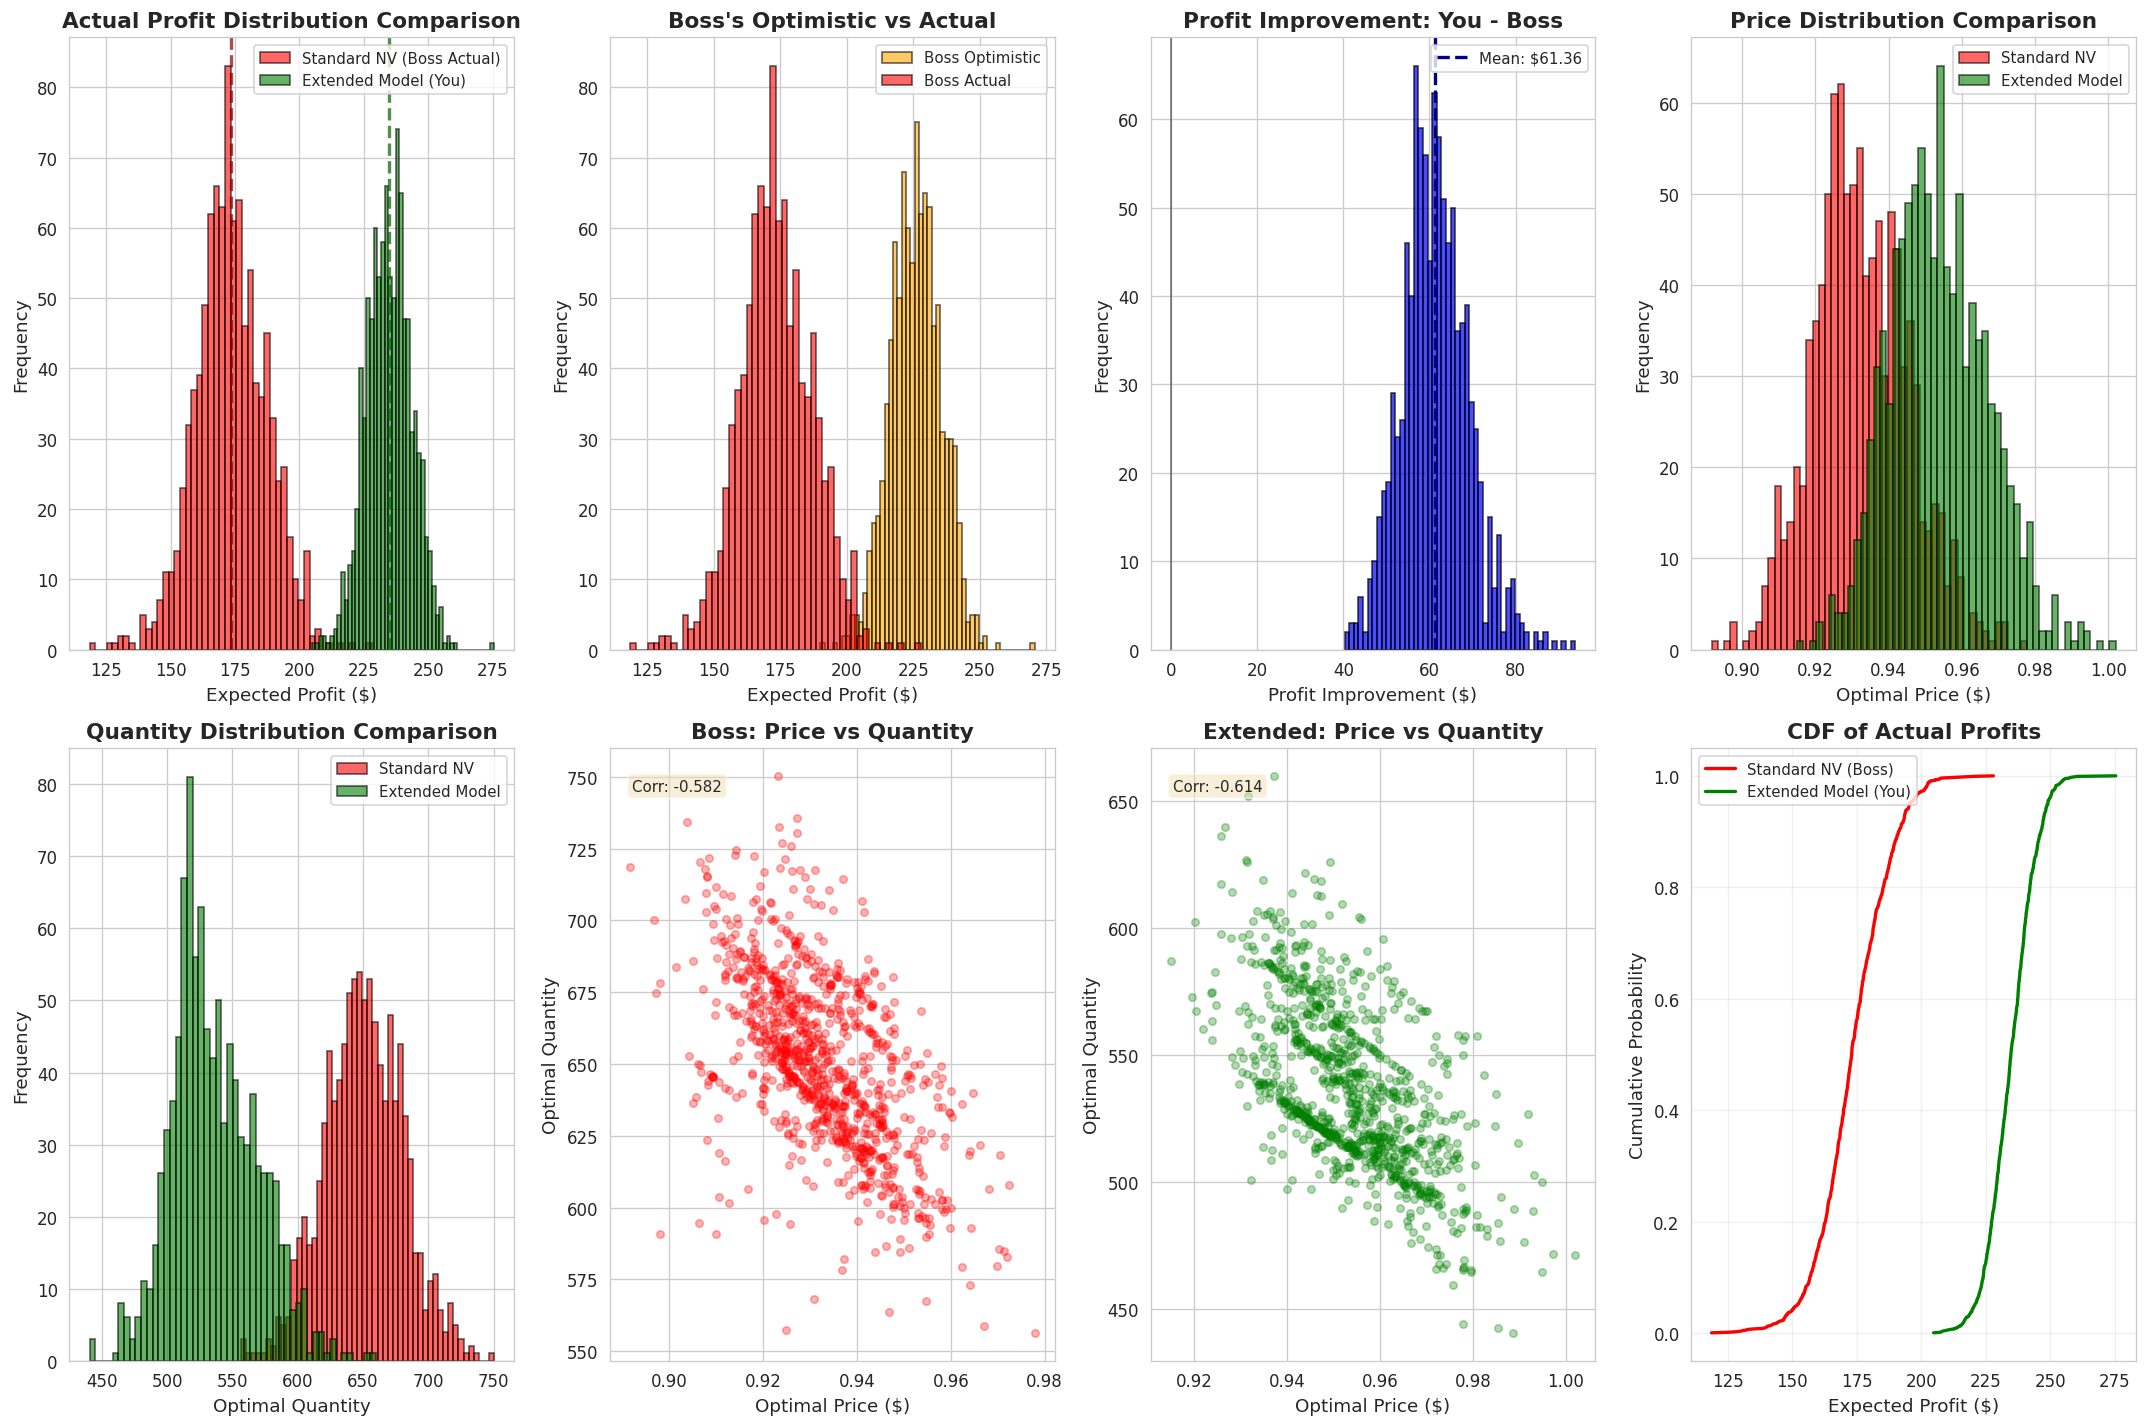


BOOTSTRAP COMPARISON SUMMARY STATISTICS

Number of bootstrap samples: 1000

----------------------------------------------------------------------
STANDARD NEWSVENDOR MODEL (Boss's Approach)
Boss optimizes price & quantity but IGNORES rush/disposal costs
----------------------------------------------------------------------
Mean Optimistic Profit: $225.95  (what boss thinks)
Mean ACTUAL Profit:     $173.45  (what boss gets)
Boss's Reality Gap:     $52.50  (cost of ignoring rush/disposal)

Median Actual Profit:   $172.99
Std Dev Actual Profit:  $13.78
Min Actual Profit:      $118.63
Max Actual Profit:      $227.93

Mean Price:             $0.93
Std Dev Price:          $0.01
Mean Quantity:          650.52
Std Dev Quantity:       30.19

----------------------------------------------------------------------
EXTENDED MODEL (Your Proposed Approach)
You optimize price & quantity WITH rush/disposal costs included
----------------------------------------------------------------------
Mean Prof

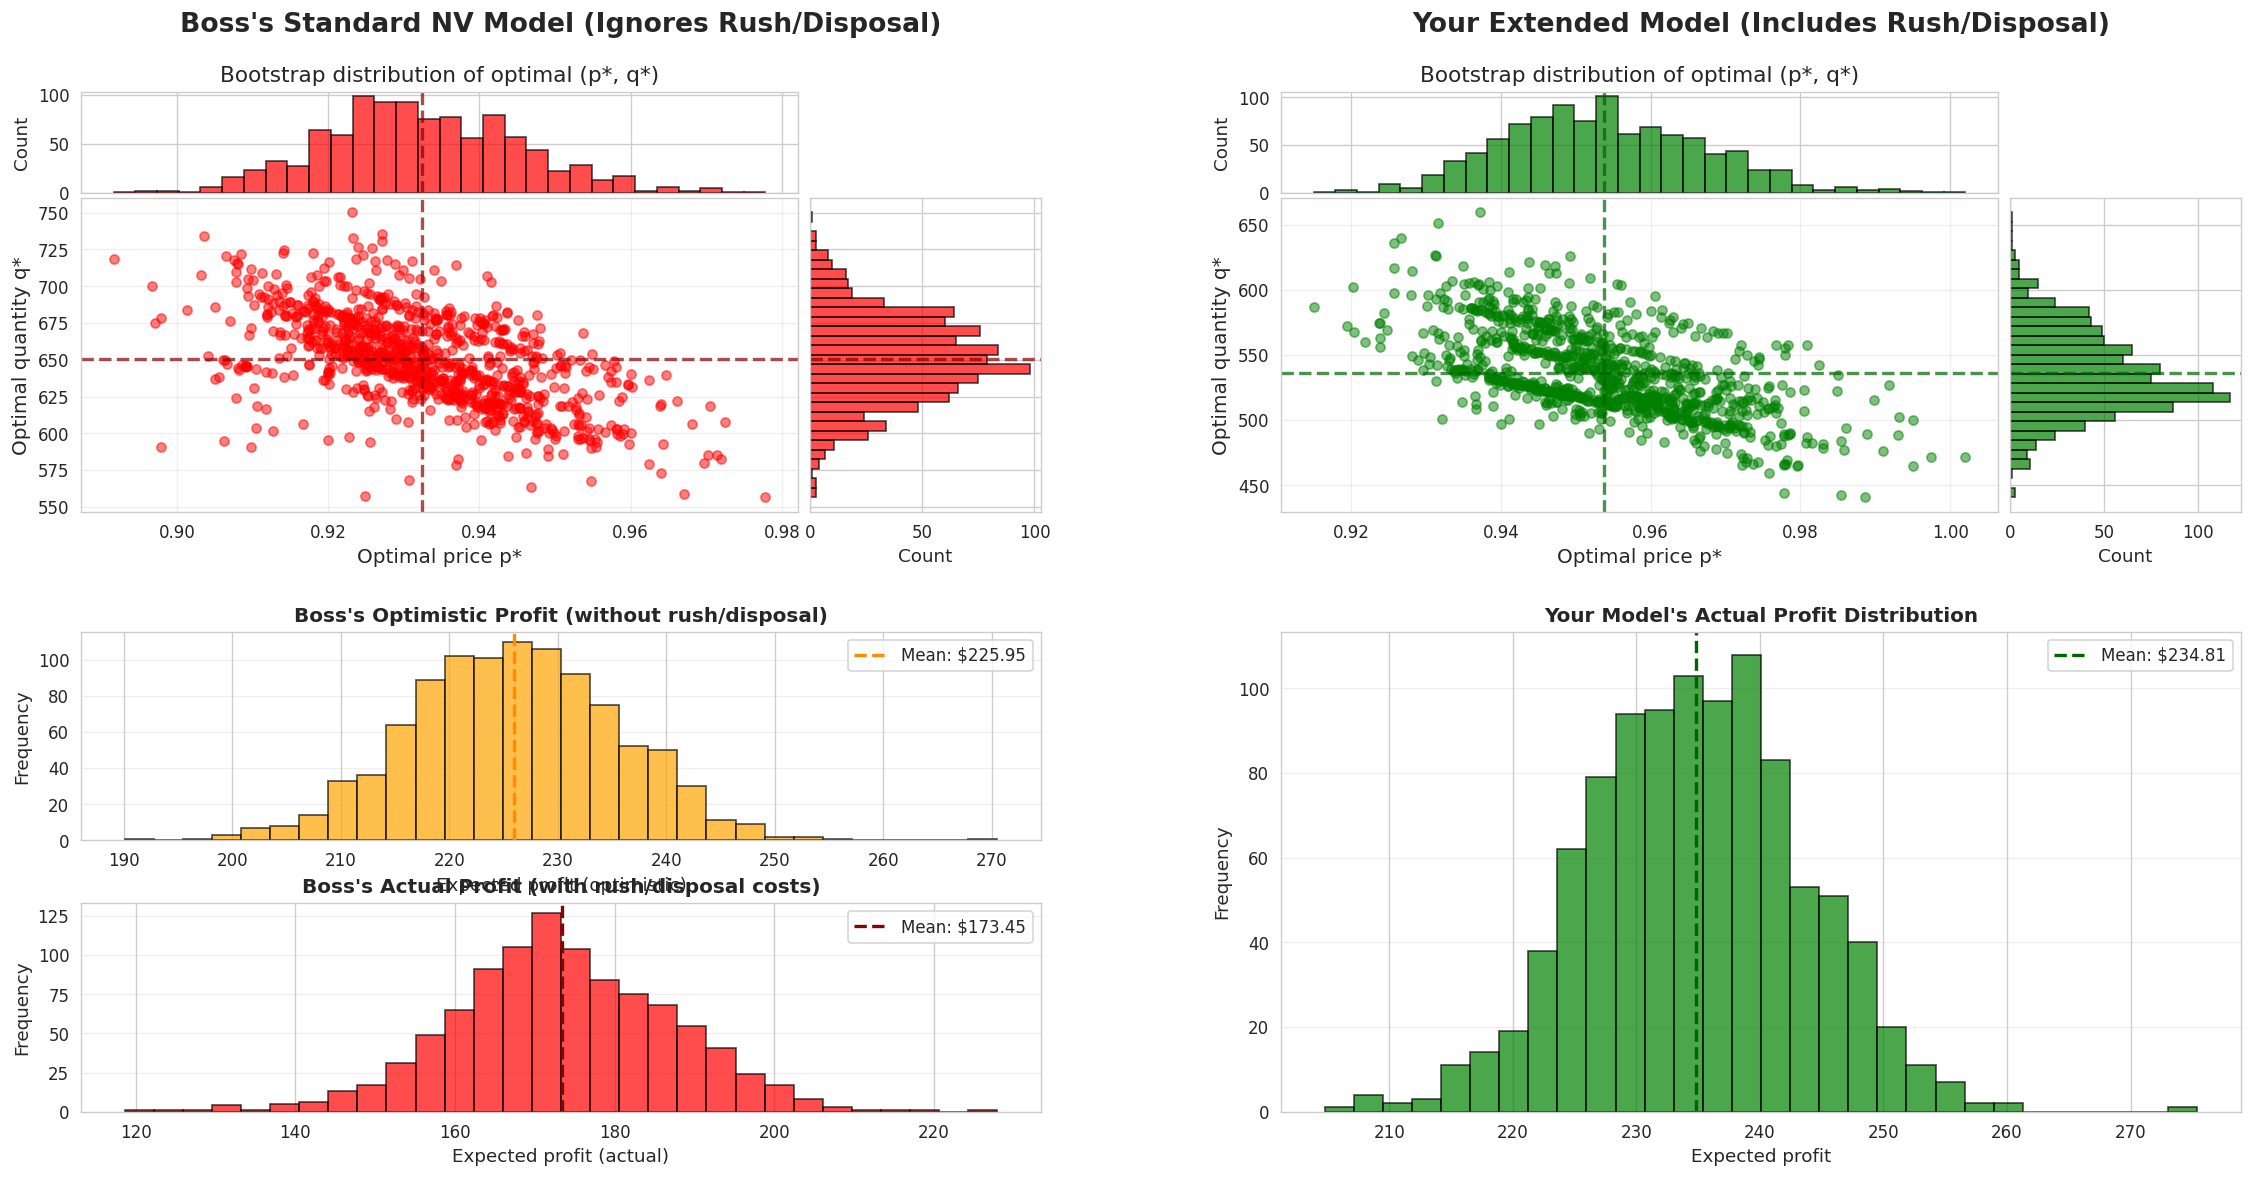


DETAILED PLOT STATISTICS

BOSS'S MODEL:
  Price:    Mean = $0.932, Std = $0.013
  Quantity: Mean = 650.52, Std = 30.19
  Reality Gap (Optimistic - Actual): $52.50

YOUR EXTENDED MODEL:
  Price:    Mean = $0.954, Std = $0.013
  Quantity: Mean = 536.13, Std = 32.38

COMPARISON:
  Price Difference (You - Boss):    $+0.021
  Quantity Difference (You - Boss): -114.39
  Profit Difference (You - Boss):   $+61.36

\nYour model beats boss's model in 1000 out of 1000 bootstrap samples
Average profit improvement: $61.36


In [ ]:

# Assuming you have:
# - price_data: your original price observations from the dataset
# - demand_data: your original demand observations from the dataset
# - solve_optimal_price_quantity: your function (already defined) with rush/disposal costs

# Run bootstrap comparison
results = bootstrap_model_comparison(
    original_price_data=df['price'],
    original_demand_data=df['demand'],
    solve_extended_model_func=solve_optimal_price_quantity,  # Pass your existing function
    n_bootstrap=1000,
    c=0.5,
    g=0.75,
    t=0.15,
    verbose=True
)

# Visualize and analyze results
visualize_bootstrap_comparison(results)

# Access specific results if needed
print(f"\\nYour model beats boss's model in {np.sum(results['extended_actual_profits'] > results['boss_actual_profits'])} out of {len(results['boss_actual_profits'])} bootstrap samples")
print(f"Average profit improvement: ${np.mean(results['extended_actual_profits'] - results['boss_actual_profits']):.2f}")
